In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
OAuth 2.0 RFC6749,63.917183,5.810653,8.539794,11
pfSense,100.783742,8.398645,15.745167,12
Accounting,105.299342,6.194079,12.634022,17
"The Starless Crown, Rollins",111.912807,4.144919,10.997812,27
Pandas,153.101509,51.033836,59.357827,3
Python + Oauth2.0,399.233497,17.357978,27.525274,23
Azure Files Documentation,499.163394,15.598856,26.733143,32
Azure DevOps Pipelines,642.840684,107.140114,180.190761,6
Terraform,978.494525,97.849452,223.071730,10
Azure Developer Associate,1107.445098,221.489020,312.966315,5


# Histogram

sum of ages: ~49684.97


<Axes: >

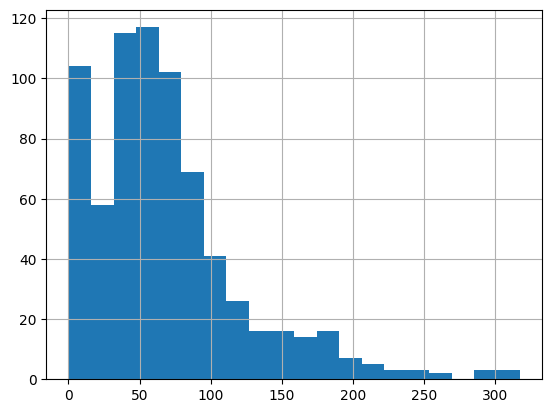

In [4]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~49684.97


<Axes: >

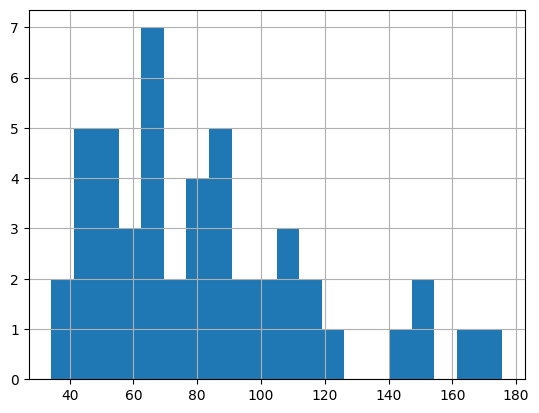

In [5]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Microsoft Purview']['age'].hist(bins=20)

# Completely Random Shuffle

In [6]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [7]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [8]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [9]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [10]:
n = 3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

if existing_cards['age'].sum() > 0:
    existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 720
Total card age: 49684.97


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
51,Python,Q:\nWhat is the primary purpose of exit codes ...,d5ae26a1eb6bf1e733080a8396f21e2d,316.986919,94.564897,-316.986919,5011.939564,0.763788,53,0,0,-316.986919
52,Python,Q:\nHow can you display help messages for comm...,bce20d24a97546798e080c25c5a8e43b,176.426856,94.564897,-316.986919,5011.939564,0.763788,53,3,0,-176.426856
53,Python,Q:\nHow do you add a required positional argum...,c0201a38417ca76ea898079c48323d39,153.077021,94.564897,-316.986919,5011.939564,0.763788,53,6,0,-153.077021
54,Python,Q:\nHow can you nest multiple tqdm progress ba...,9239afbc6a793b11a53d279b51771fd8,127.002806,94.564897,-316.986919,5011.939564,0.763788,53,9,0,-127.002806
55,Python,Q:\nName a common use case for generators in P...,2aba734c090b45cee3552b76252224d3,110.889972,94.564897,-316.986919,5011.939564,0.763788,53,12,0,-110.889972
546,Python,Q:\nWhat function from the os module is used t...,3372af51876bb27b0c1de083ad1ac194,97.706209,94.564897,-316.986919,5011.939564,0.763788,53,15,0,-97.706209
547,Python,"Q:\nWhat is lazy evaluation, and how do genera...",2916065a4a1c2389fc0c4062909198ca,92.091827,94.564897,-316.986919,5011.939564,0.763788,53,18,0,-92.091827
58,Python,How do you resolve a relative path to an absol...,51bcf0bea82ec86eae6817d34b301707,87.453291,94.564897,-316.986919,5011.939564,0.763788,53,21,0,-87.453291
59,Python,Q:\nHow can you raise an exception inside a ge...,e8a67cc29be602bfa76630ddade40494,84.475291,94.564897,-316.986919,5011.939564,0.763788,53,24,0,-84.475291
60,Python,Q:\nWhat is the purpose of the raise ... from ...,3568df2062d1e05d4cd1c11c4c8326d9,78.065579,94.564897,-316.986919,5011.939564,0.763788,53,27,0,-78.065579


## Card Count

In [11]:
# n=4
# # existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [12]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [13]:
existing_cards.head(10)['age'].sum()

np.float64(1324.1757703920741)

In [14]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
51,Python,Q:\nWhat is the primary purpose of exit codes ...,d5ae26a1eb6bf1e733080a8396f21e2d,316.986919,94.564897,-316.986919,5011.939564,0.763788,53,0,0,-316.986919
242,Azure Developer Associate,As the .NET SDK for Azure Cosmos DB for NoSQL ...,e7d9d1bada8400673bd3bdf99e9f3c40,312.966315,221.489020,-312.966315,1107.445098,0.830150,5,0,0,-312.966315
27,FSLogix,A full VHD(x) clone is performed when Cloud Ca...,71af619ba0f37ffd62aa637176cd6ef4,312.645067,97.234531,-312.645067,1750.221560,0.938220,18,0,0,-312.645067
33,Asynchronous Python,"Thread Pool Executor\nA thread pool executor, ...",102c628cf04ad4661a71d437cd297a11,290.820021,96.865736,-290.820021,2712.240611,0.665325,28,0,0,-290.820021
299,Python,Q:\nHow can you define a custom exception in P...,42a1f83efefd4b56173827e48cae56f3,288.924079,94.564897,-316.986919,5011.939564,0.763788,53,1,1,-288.924079
92,Vocab,"How to Sell a Haunted House, Hendrix\nDebride ...",1cbf1056a2336f69233d814a8be086c8,287.523481,89.678812,-287.523481,4394.261796,0.451574,49,0,0,-287.523481
486,Azure Developer Associate,"Q: In Azure Storage, which feature allows revo...",b18514066eebd7faf9c8ac3843d058c0,257.215693,221.489020,-312.966315,1107.445098,0.830150,5,1,1,-257.215693
69,PnP PowerShell,Remove-PnPFile (PnP.PowerShell)\nDeletes a spe...,82aa6d1579ce68a7efaf6bae61eb3a03,256.733105,93.151435,-256.733105,3539.754529,0.177430,38,0,0,-256.733105
317,PnP PowerShell,Invoke-RestMethod Parameters\nKey parameters i...,e6a04d0a76f2a4a9cba720d23ffea2c8,252.774757,93.151435,-256.733105,3539.754529,0.177430,38,1,1,-252.774757
282,Asynchronous Python,asyncio.wait_for()\nRuns a coroutine with a ti...,0ccadcbce46e58eb4de4907f7e86cbf9,250.036584,96.865736,-290.820021,2712.240611,0.665325,28,1,1,-250.036584


In [15]:
existing_cards['age'].mean()

np.float64(69.00689601095596)